In [1]:
import pickle
from urllib.request import urlopen
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
np.random.RandomState(42)

import seaborn as sns

#import unittest
from nose.tools import *

import time
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
from sklearn import preprocessing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
data1 = pd.read_parquet(Path("data") / "test.parquet")

In [4]:
df1 = pd.read_csv('2020.csv')

In [5]:
df2 = pd.read_csv('2021.csv')

In [6]:
dates20 = ["2020-01-01",'2020-04-10','2020-04-13','2020-05-01','2020-05-08','2020-05-21','2020-05-31','2020-06-01','2020-07-14','2020-08-15','2020-11-01','2020-11-11','2020-12-25','2020-12-26']

In [7]:
dates21 = ["2021-01-01",'2021-04-02','2021-04-05','2021-05-01','2021-05-08','2021-05-13','2021-05-23','2021-05-24','2021-07-14','2021-08-15','2021-11-01','2021-11-11','2021-12-25','2021-12-26']

In [8]:
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates20]
df1["date"] = pd.to_datetime(df1["date"])

In [9]:
df1['holiday'] = df1['date'].isin(dates_list)
df1.holiday = df1.holiday.replace([True, False], [1, 0])
df1.loc[:, "weekday"] = df1["date"].dt.weekday
df1['weekend'] = df1['weekday'].isin([5,6])
df1.weekend = df1.weekend.replace([True, False], [1, 0])
df1 = df1.drop('weekday', axis=1)
df1

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,2020-12-31,19,4.0,0.2,76,0.0,NaN,300.0,7.6,NaN,1006.3,NaN,NaN,0,0
8652,2020-12-31,20,3.2,-0.1,79,0.0,NaN,310.0,5.4,NaN,1006.6,NaN,NaN,0,0
8653,2020-12-31,21,3.0,-0.3,79,NaN,NaN,330.0,7.6,NaN,1007.0,NaN,NaN,0,0
8654,2020-12-31,22,2.5,-0.4,81,0.0,NaN,280.0,5.4,NaN,1007.5,NaN,NaN,0,0


In [10]:
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates21]
df2["date"] = pd.to_datetime(df2["date"])

In [11]:
df2['holiday'] = df2['date'].isin(dates_list)
df2.holiday = df2.holiday.replace([True, False], [1, 0])
df2.loc[:, "weekday"] = df2["date"].dt.weekday
df2['weekend'] = df2['weekday'].isin([5,6])
df2.weekend = df2.weekend.replace([True, False], [1, 0])
df2 = df2.drop('weekday', axis=1)
df2

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco,holiday,weekend
0,2021-01-01,0,1.6,-0.8,84,NaN,NaN,280,7.6,NaN,1008.0,NaN,NaN,1,0
1,2021-01-01,1,1.4,-1.0,84,0.0,NaN,280,5.4,NaN,1008.2,NaN,NaN,1,0
2,2021-01-01,2,0.9,-1.2,86,0.0,NaN,280,5.4,NaN,1008.6,NaN,NaN,1,0
3,2021-01-01,3,0.8,-1.1,87,NaN,NaN,280,5.4,NaN,1008.9,NaN,NaN,1,0
4,2021-01-01,4,0.6,-1.3,87,0.0,NaN,310,3.6,NaN,1009.0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,NaN,250,5.4,NaN,1026.5,NaN,NaN,0,0
8756,2021-12-31,20,12.0,10.6,91,0.0,NaN,280,11.2,NaN,1026.6,NaN,NaN,0,0
8757,2021-12-31,21,12.2,10.9,92,0.0,NaN,280,7.6,NaN,1026.6,NaN,NaN,0,0
8758,2021-12-31,22,12.0,10.6,91,0.0,NaN,270,3.6,NaN,1026.7,NaN,NaN,0,0


In [12]:
df1.loc[:, "season"] = df1["date"].dt.month
df1.season = df1.season.replace([1,2,3,4,5,6,7,8,9,10,11,12], [3,3,3,0,0,1,1,1,1,2,2,3])
df1

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,season
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,3
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,3
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,3
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,3
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,2020-12-31,19,4.0,0.2,76,0.0,NaN,300.0,7.6,NaN,1006.3,NaN,NaN,0,0,3
8652,2020-12-31,20,3.2,-0.1,79,0.0,NaN,310.0,5.4,NaN,1006.6,NaN,NaN,0,0,3
8653,2020-12-31,21,3.0,-0.3,79,NaN,NaN,330.0,7.6,NaN,1007.0,NaN,NaN,0,0,3
8654,2020-12-31,22,2.5,-0.4,81,0.0,NaN,280.0,5.4,NaN,1007.5,NaN,NaN,0,0,3


In [13]:
df2.loc[:, "season"] = df2["date"].dt.month
df2.season = df2.season.replace([1,2,3,4,5,6,7,8,9,10,11,12], [3,3,3,0,0,1,1,1,1,2,2,3])
df2

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco,holiday,weekend,season
0,2021-01-01,0,1.6,-0.8,84,NaN,NaN,280,7.6,NaN,1008.0,NaN,NaN,1,0,3
1,2021-01-01,1,1.4,-1.0,84,0.0,NaN,280,5.4,NaN,1008.2,NaN,NaN,1,0,3
2,2021-01-01,2,0.9,-1.2,86,0.0,NaN,280,5.4,NaN,1008.6,NaN,NaN,1,0,3
3,2021-01-01,3,0.8,-1.1,87,NaN,NaN,280,5.4,NaN,1008.9,NaN,NaN,1,0,3
4,2021-01-01,4,0.6,-1.3,87,0.0,NaN,310,3.6,NaN,1009.0,NaN,NaN,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,NaN,250,5.4,NaN,1026.5,NaN,NaN,0,0,3
8756,2021-12-31,20,12.0,10.6,91,0.0,NaN,280,11.2,NaN,1026.6,NaN,NaN,0,0,3
8757,2021-12-31,21,12.2,10.9,92,0.0,NaN,280,7.6,NaN,1026.6,NaN,NaN,0,0,3
8758,2021-12-31,22,12.0,10.6,91,0.0,NaN,270,3.6,NaN,1026.7,NaN,NaN,0,0,3


In [ ]:
df2.loc[:, "is_night"] = df2["hour"]
#df2.season = df2.season.replace([1,2,3,4,5,6,7,8,9,10,11,12], [3,3,3,0,0,1,1,1,1,2,2,3])
df2.drop('is_night',axis=1)

In [14]:
df1['is_night'] = 0
df1.loc[(df1['hour'] < 8) | (df1['hour'] > 20), 'is_night'] = 1
df1

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,season,is_night
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,3,1
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,3,1
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,3,1
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,3,1
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,2020-12-31,19,4.0,0.2,76,0.0,NaN,300.0,7.6,NaN,1006.3,NaN,NaN,0,0,3,0
8652,2020-12-31,20,3.2,-0.1,79,0.0,NaN,310.0,5.4,NaN,1006.6,NaN,NaN,0,0,3,0
8653,2020-12-31,21,3.0,-0.3,79,NaN,NaN,330.0,7.6,NaN,1007.0,NaN,NaN,0,0,3,1
8654,2020-12-31,22,2.5,-0.4,81,0.0,NaN,280.0,5.4,NaN,1007.5,NaN,NaN,0,0,3,1


In [15]:
df2['is_night'] = 0
df2.loc[(df2['hour'] < 8) | (df2['hour'] > 20), 'is_night'] = 1
df2

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco,holiday,weekend,season,is_night
0,2021-01-01,0,1.6,-0.8,84,NaN,NaN,280,7.6,NaN,1008.0,NaN,NaN,1,0,3,1
1,2021-01-01,1,1.4,-1.0,84,0.0,NaN,280,5.4,NaN,1008.2,NaN,NaN,1,0,3,1
2,2021-01-01,2,0.9,-1.2,86,0.0,NaN,280,5.4,NaN,1008.6,NaN,NaN,1,0,3,1
3,2021-01-01,3,0.8,-1.1,87,NaN,NaN,280,5.4,NaN,1008.9,NaN,NaN,1,0,3,1
4,2021-01-01,4,0.6,-1.3,87,0.0,NaN,310,3.6,NaN,1009.0,NaN,NaN,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,NaN,250,5.4,NaN,1026.5,NaN,NaN,0,0,3,0
8756,2021-12-31,20,12.0,10.6,91,0.0,NaN,280,11.2,NaN,1026.6,NaN,NaN,0,0,3,0
8757,2021-12-31,21,12.2,10.9,92,0.0,NaN,280,7.6,NaN,1026.6,NaN,NaN,0,0,3,1
8758,2021-12-31,22,12.0,10.6,91,0.0,NaN,270,3.6,NaN,1026.7,NaN,NaN,0,0,3,1


In [16]:
weather = pd.concat([df1, df2], ignore_index=True)
weather = weather.drop(columns=['snow', 'wpgt','tsun','coco','Coco'])

In [17]:
weather

,date,hour,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
0,2020-01-01,0,0.8,-0.1,94,NaN,170.0,5.4,1032.5,1,0,3,1
1,2020-01-01,1,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,3,1
2,2020-01-01,2,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,3,1
3,2020-01-01,3,0.0,-0.3,98,NaN,220.0,5.4,1031.9,1,0,3,1
4,2020-01-01,4,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,3,0
17412,2021-12-31,20,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,3,0
17413,2021-12-31,21,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,3,1
17414,2021-12-31,22,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,3,1


In [19]:
weather["hour"] = pd.to_timedelta(weather['hour'], unit='h')
weather['date'] = weather['date'] + weather['hour']
weather = weather.drop(columns=['hour'])
weather = weather.fillna(method='bfill')
weather

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,3,1
1,2020-01-01 02:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,3,1
2,2020-01-01 04:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,3,1
3,2020-01-01 06:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,3,1
4,2020-01-01 08:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2022-01-01 14:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,3,0
17412,2022-01-01 16:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,3,0
17413,2022-01-01 18:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,3,1
17414,2022-01-01 20:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,3,1


In [20]:
train_merged = data.merge(weather, on='date')

In [21]:
test_merged = data1.merge(weather, on='date')

In [22]:
train_merged

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,8.5,48,0.0,350.0,5.4,1020.7,0,0,1,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,9.6,77,0.0,330.0,3.6,1020.1,0,0,1,1
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,8.5,48,0.0,350.0,5.4,1020.7,0,0,1,0
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,9.6,77,0.0,330.0,3.6,1020.1,0,0,1,1
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,5.0,2020-09-01 02:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,8.5,48,0.0,350.0,5.4,1020.7,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450511,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,14.0,2021-08-09 22:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,13.5,66,0.0,220.0,18.4,1017.8,0,0,1,0
450512,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,11.9,74,0.0,220.0,7.6,1016.3,0,1,1,1
450513,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,13.5,66,0.0,220.0,18.4,1017.8,0,0,1,0
450514,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,18.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,11.9,74,0.0,220.0,7.6,1016.3,0,1,1,1


In [23]:
test_merged

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,12.7,57,0.0,240.0,16.6,1017.5,0,0,1,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,15.1,88,0.1,260.0,7.6,1017.7,0,0,1,1
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,12.7,57,0.0,240.0,16.6,1017.5,0,0,1,0
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,15.1,88,0.1,260.0,7.6,1017.7,0,0,1,1
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,62.0,2021-08-10 06:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,12.7,57,0.0,240.0,16.6,1017.5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41547,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,127.0,2021-09-09 12:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,18.9,94,0.1,220.0,7.6,1011.1,0,0,1,1
41548,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,18.3,58,0.0,240.0,11.2,1009.6,0,0,1,0
41549,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,18.9,94,0.1,220.0,7.6,1011.1,0,0,1,1
41550,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,126.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,18.3,58,0.0,240.0,11.2,1009.6,0,0,1,0


/var/folders/8k/k9xm2h815_70khp7lnm6l0f40000gn/T/ipykernel_1457/978757208.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(london[col], ax=axs,**kwargs)


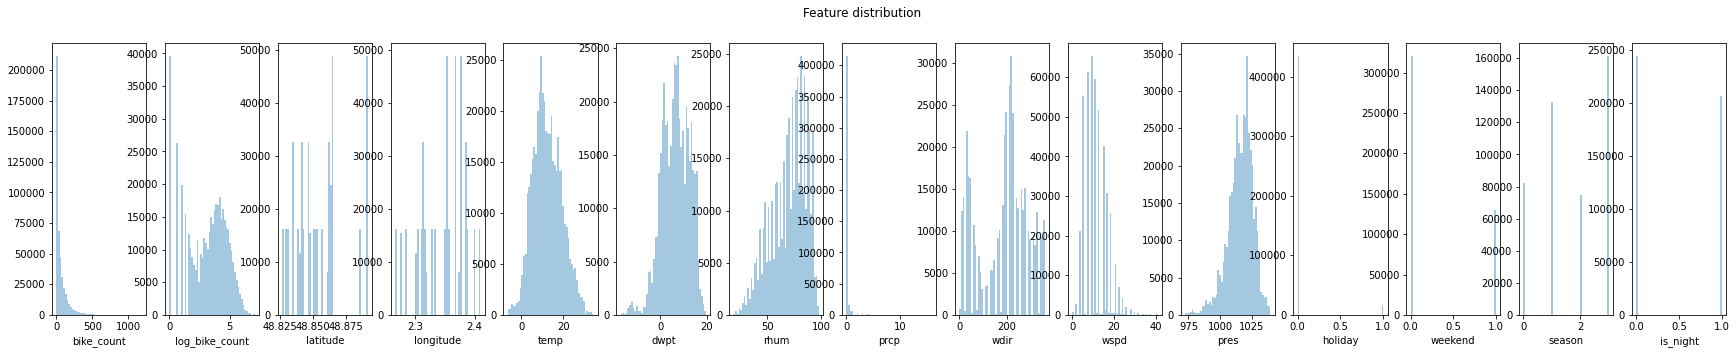

In [24]:
cols = ['bike_count','log_bike_count','latitude','longitude','temp','dwpt','rhum','prcp','wdir','wspd','pres','holiday','weekend','season','is_night']
def plot_distribution(london,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    Note: String columns should be dropped before passing to the function.
    """
    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(london[col], ax=axs,**kwargs)
    fig.suptitle('Feature distribution')
    
plot_distribution(train_merged,cols, kde=False)

In [25]:
train_merged_non_weekend = train_merged[train_merged['weekend'] == 0]
train_merged_non_weekend = train_merged_non_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_weekend = train_merged[train_merged['weekend'] == 1]
train_merged_is_weekend = train_merged_is_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_holiday = train_merged[train_merged['holiday'] == 1]
train_merged_is_holiday = train_merged_is_holiday.drop(['holiday','weekend'],axis=1)
train_merged_non_holiday = train_merged[train_merged['holiday'] == 0]
train_merged_non_holiday = train_merged_non_holiday.drop(['holiday','weekend'],axis=1)


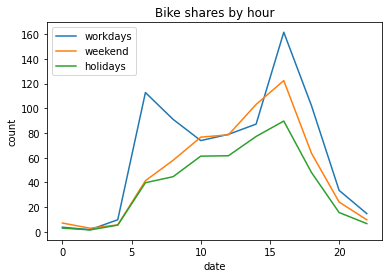

In [27]:
def hourly_plot(df,title):
    """
    Function for plotting bike shares by hour.
    input: 
    df - pandas dataframe 
    title - main title of the plot
    
    """
    assert_true('date' in set(df.columns))
    assert_true('bike_count' in set(df.columns))
    
    df.groupby(by=df.date.dt.hour)['bike_count'].mean().plot()
    plt.title(title)
    plt.ylabel('count')
    plt.legend(['workdays','weekend','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(train_merged_non_weekend, 'Bike shares by hour')
hourly_plot(train_merged_is_weekend, 'Bike shares by hour')
hourly_plot(train_merged_is_holiday, 'Bike shares by hour')


In [28]:
train_merged.corr()

/var/folders/8k/k9xm2h815_70khp7lnm6l0f40000gn/T/ipykernel_1457/4163707767.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_merged.corr()


,site_id,bike_count,latitude,longitude,log_bike_count,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
site_id,1.000000,-0.003933,-0.128072,-0.186795,0.019872,-0.008281,-0.019747,-0.017294,0.002258,-0.006777,0.009924,0.002260,0.008414,-0.000152,-0.003491,0.000066
bike_count,-0.003933,1.000000,0.128744,0.014627,0.738237,0.114762,0.096287,-0.042034,-0.020875,-0.021695,-0.081441,0.049374,-0.048225,-0.075814,-0.085953,-0.085587
latitude,-0.128072,0.128744,1.000000,0.153338,0.108380,0.000738,0.002046,0.002004,-0.000354,0.000951,-0.001056,0.000244,-0.001214,0.000061,0.001264,-0.000006
longitude,-0.186795,0.014627,0.153338,1.000000,0.044525,-0.000142,0.001115,0.002043,-0.000744,0.001664,-0.000648,0.002519,-0.002289,0.000264,0.004955,-0.000011
log_bike_count,0.019872,0.738237,0.108380,0.044525,1.000000,0.116834,0.121834,-0.005959,-0.015918,-0.014728,-0.097540,0.032145,-0.052958,-0.070707,-0.097064,-0.075634
temp,-0.008281,0.114762,0.000738,-0.000142,0.116834,1.000000,0.804708,-0.426236,0.006280,0.047626,-0.078517,-0.008077,-0.058580,-0.048956,-0.508321,-0.245272
dwpt,-0.019747,0.096287,0.002046,0.001115,0.121834,0.804708,1.000000,0.184402,0.133207,0.187328,-0.142970,-0.195874,-0.048878,-0.021170,-0.335285,-0.016306
rhum,-0.017294,-0.042034,0.002004,0.002043,-0.005959,-0.426236,0.184402,1.000000,0.214299,0.201687,-0.098999,-0.316501,0.013758,0.041846,0.349112,0.382423
prcp,0.002258,-0.020875,-0.000354,-0.000744,-0.015918,0.006280,0.133207,0.214299,1.000000,0.073218,0.060599,-0.188728,-0.015613,0.003322,0.013243,0.000456
wdir,-0.006777,-0.021695,0.000951,0.001664,-0.014728,0.047626,0.187328,0.201687,0.073218,1.000000,-0.028848,-0.202055,0.031126,-0.059023,0.051180,-0.018177


In [29]:
test_merged.corr()

/var/folders/8k/k9xm2h815_70khp7lnm6l0f40000gn/T/ipykernel_1457/2105244982.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_merged.corr()


,site_id,bike_count,latitude,longitude,log_bike_count,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,season,is_night
site_id,1.000000e+00,-0.000297,-1.499695e-01,-2.167197e-01,0.034659,4.396150e-16,1.015837e-15,2.317152e-16,9.192105e-17,-6.121608e-16,-3.264277e-16,-3.784313e-16,-4.995492e-16,-4.096561e-16,NaN,3.283681e-17
bike_count,-2.973631e-04,1.000000,1.495820e-01,8.511081e-03,0.745094,-2.636024e-02,-8.892510e-03,2.473620e-02,-2.127924e-02,-1.116365e-01,7.862507e-03,2.857824e-02,-5.207113e-02,-7.780552e-02,NaN,-1.013098e-01
latitude,-1.499695e-01,0.149582,1.000000e+00,1.615004e-01,0.182529,1.387887e-12,1.260119e-12,-4.427440e-13,-1.218065e-13,-4.268320e-12,1.353382e-12,-7.606543e-13,-1.937026e-12,6.400837e-13,NaN,2.801859e-14
longitude,-2.167197e-01,0.008511,1.615004e-01,1.000000e+00,0.044999,-7.406079e-15,-1.521597e-14,-5.059712e-15,1.422992e-15,7.983849e-14,-3.032308e-14,1.352714e-14,5.089416e-14,-4.769215e-15,NaN,-1.699859e-16
log_bike_count,3.465937e-02,0.745094,1.825292e-01,4.499866e-02,1.000000,-5.252180e-02,-1.255074e-02,4.980951e-02,-2.049296e-02,-1.005559e-01,-1.283994e-02,1.224498e-04,-4.442051e-02,-5.621760e-02,NaN,-8.199030e-02
temp,4.396150e-16,-0.026360,1.387887e-12,-7.406079e-15,-0.052522,1.000000e+00,4.410535e-01,-8.025453e-01,-3.979052e-03,9.174338e-02,-9.821920e-02,-3.577600e-01,1.558877e-01,8.486311e-02,NaN,-6.145191e-01
dwpt,1.015837e-15,-0.008893,1.260119e-12,-1.521597e-14,-0.012551,4.410535e-01,1.000000e+00,1.680787e-01,1.899112e-01,2.337449e-01,-3.500409e-01,-4.922784e-01,1.100990e-01,1.750071e-01,NaN,-1.277924e-01
rhum,2.317152e-16,0.024736,-4.427440e-13,-5.059712e-15,0.049810,-8.025453e-01,1.680787e-01,1.000000e+00,1.365162e-01,4.516840e-02,-1.234121e-01,7.136503e-02,-1.045011e-01,1.449225e-02,NaN,6.145280e-01
prcp,9.192105e-17,-0.021279,-1.218065e-13,1.422992e-15,-0.020493,-3.979052e-03,1.899112e-01,1.365162e-01,1.000000e+00,7.297613e-02,-2.892863e-02,-1.230285e-01,-1.636005e-02,-1.477254e-02,NaN,5.125571e-02
wdir,-6.121608e-16,-0.111637,-4.268320e-12,7.983849e-14,-0.100556,9.174338e-02,2.337449e-01,4.516840e-02,7.297613e-02,1.000000e+00,-2.247969e-01,-3.412684e-01,1.865727e-01,2.603306e-02,NaN,-1.271792e-02


In [32]:
def add_hour(df):
    """
    The function is extracting the hour of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    
    df['hour'] = df['date'].dt.hour
    
    assert_true('hour' in set(df.columns))
    return df

In [33]:
def add_month(df):
    """
    The function is extracting the month of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    
    df['month'] = df['date'].dt.month
    
    assert_true('month' in set(df.columns))
    return df

In [34]:
add_month(train_merged)
add_hour(train_merged)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,prcp,wdir,wspd,pres,holiday,weekend,season,is_night,month,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,350.0,5.4,1020.7,0,0,1,0,9,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,330.0,3.6,1020.1,0,0,1,1,9,2
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,350.0,5.4,1020.7,0,0,1,0,9,2
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,330.0,3.6,1020.1,0,0,1,1,9,2
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,5.0,2020-09-01 02:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,0.0,350.0,5.4,1020.7,0,0,1,0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450511,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,14.0,2021-08-09 22:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,0.0,220.0,18.4,1017.8,0,0,1,0,8,22
450512,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.0,220.0,7.6,1016.3,0,1,1,1,8,22
450513,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.0,220.0,18.4,1017.8,0,0,1,0,8,22
450514,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,18.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.0,220.0,7.6,1016.3,0,1,1,1,8,22


In [35]:
add_month(test_merged)
add_hour(test_merged)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,prcp,wdir,wspd,pres,holiday,weekend,season,is_night,month,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,240.0,16.6,1017.5,0,0,1,0,8,6
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.1,260.0,7.6,1017.7,0,0,1,1,8,6
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.0,240.0,16.6,1017.5,0,0,1,0,8,6
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0.1,260.0,7.6,1017.7,0,0,1,1,8,6
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,62.0,2021-08-10 06:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,0.0,240.0,16.6,1017.5,0,0,1,0,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41547,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,127.0,2021-09-09 12:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,0.1,220.0,7.6,1011.1,0,0,1,1,9,12
41548,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.0,240.0,11.2,1009.6,0,0,1,0,9,12
41549,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.1,220.0,7.6,1011.1,0,0,1,1,9,12
41550,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,126.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0.0,240.0,11.2,1009.6,0,0,1,0,9,12


In [36]:
def add_encode(df, column, max_value):
    """
    The function is encoding time series cyclical features with sin and cos.
    Input: 
    ---------
    df - pandas DataFrame
    column - column name
    max_value - column max value
    Output: 
    -----------
    -same dataframe with _sin and _cos columns added
    """
    assert_true(column in set(df.columns))
    
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    
    assert_true((column + '_sin') in set(df.columns))
    assert_true((column + '_cos') in set(df.columns))
    return df

In [37]:
add_encode(train_merged,'hour',23)
add_encode(train_merged,'month',12)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,holiday,weekend,season,is_night,month,hour,hour_sin,hour_cos,month_sin,month_cos
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,0,9,2,0.519584,0.854419,-1.000000,-1.836970e-16
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,1,9,2,0.519584,0.854419,-1.000000,-1.836970e-16
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,0,9,2,0.519584,0.854419,-1.000000,-1.836970e-16
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,2.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,1,9,2,0.519584,0.854419,-1.000000,-1.836970e-16
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,5.0,2020-09-01 02:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,0,0,1,0,9,2,0.519584,0.854419,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450511,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,14.0,2021-08-09 22:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,0,0,1,0,8,22,-0.269797,0.962917,-0.866025,-5.000000e-01
450512,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,1,1,1,8,22,-0.269797,0.962917,-0.866025,-5.000000e-01
450513,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,21.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,0,1,0,8,22,-0.269797,0.962917,-0.866025,-5.000000e-01
450514,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,18.0,2021-08-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,1,1,1,8,22,-0.269797,0.962917,-0.866025,-5.000000e-01


In [38]:
add_encode(test_merged,'hour',23)
add_encode(test_merged,'month',12)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,holiday,weekend,season,is_night,month,hour,hour_sin,hour_cos,month_sin,month_cos
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,0,8,6,0.997669,-0.068242,-0.866025,-5.000000e-01
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,1,8,6,0.997669,-0.068242,-0.866025,-5.000000e-01
2,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,0,8,6,0.997669,-0.068242,-0.866025,-5.000000e-01
3,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,40.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,0,0,1,1,8,6,0.997669,-0.068242,-0.866025,-5.000000e-01
4,100036718-104036718,39 quai François Mauriac NO-SE,100036718,39 quai François Mauriac,62.0,2021-08-10 06:00:00,2017-07-12,Y2H17021629,48.834360,2.377000,...,0,0,1,0,8,6,0.997669,-0.068242,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41547,100063175-353277235,20 Avenue de Clichy SE-NO,100063175,20 Avenue de Clichy,127.0,2021-09-09 12:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,...,0,0,1,1,9,12,-0.136167,-0.990686,-1.000000,-1.836970e-16
41548,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,0,1,0,9,12,-0.136167,-0.990686,-1.000000,-1.836970e-16
41549,300014702-353245972,254 rue de Vaugirard NE-SO,300014702,254 rue de Vaugirard,90.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,0,1,1,9,12,-0.136167,-0.990686,-1.000000,-1.836970e-16
41550,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,126.0,2021-09-09 12:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,...,0,0,1,0,9,12,-0.136167,-0.990686,-1.000000,-1.836970e-16


In [ ]:
train_merged[train_merged['log_bike_count']>3].groupby(by='hour').count()

In [ ]:
def sns_hist(data,title):
    """"
    Function to plot seaborn histogram.
    """
    assert_is_not_none(data)
    
    sns.distplot(data, fit=norm)
    plt.title(title)
    plt.ylabel('Density')

In [ ]:
sns_hist(train_merged[train_merged['is_night']==1]['log_bike_count'],"during the night.")

In [ ]:
sns_hist(train_merged[train_merged['is_night']==0]['log_bike_count'],"during the day.")